# Introdução

Esse Notebook será responsável pelo preprocessamento dos dados contidos em ./data/raw para formatos compatíveis e otimizados para o treinamento de cada modelo
As definições dos parâmetros do treinamento aos quais os modelos deverão solucionar já foram definidas no notebook "Coleta de Dados"

Modelos a serem Criados:

1. Modelo Linear: MLP sem funções de ativação, composta apenas de somas lineares
2. MLP: rede neural - efetivamente identica ao modelo linear, no entanto, apresenta função de ativação ao final do somatório de funções lineares
3. LSTM: Um modelo de rede neural recorrente, com capacidade de diferenciação de informação de curto e longo prazo
4. TFT: Modelo baseado em LLMs desenvolvido pela microsoft - servirá como um comparativo mais moderno


## Dependências

In [22]:
import os
import importlib

print("🔧 Ambiente: PyTorch + Lightning + Forecasting (GPU)")

# ==============================================
# 1) INSTALAR PYTORCH (GPU se disponível)
# ==============================================
has_gpu = os.system("nvidia-smi > /dev/null 2>&1") == 0

try:
    import torch
    print(f"torch={torch.__version__} | cuda={torch.cuda.is_available()}")
except Exception:
    print("⚙️ Instalando PyTorch (CUDA 12.1)...")

    # remove qualquer torch quebrado
    os.system("pip uninstall -y torch torchvision torchaudio nvidia-*")

    if has_gpu:
        os.system(
            "pip install torch torchvision torchaudio "
            "--index-url https://download.pytorch.org/whl/cu121 --quiet"
        )
    else:
        os.system(
            "pip install torch torchvision torchaudio "
            "--index-url https://download.pytorch.org/whl/cpu --quiet"
        )

    importlib.invalidate_caches()
    import torch
    print(f"✔️ torch={torch.__version__} | cuda={torch.cuda.is_available()}")


# ==============================================
# 2) INSTALL PYTORCH-LIGHTNING + FORECASTING
# ==============================================
try:
    import lightning
    import pytorch_forecasting
    print("✔️ PyTorch Lightning + Forecasting ok")
except ImportError:
    print("📦 Instalando Lightning + PyTorch Forecasting...")
    os.system("pip install lightning pytorch-forecasting --quiet")


# ==============================================
# 3) INSTALAR PARQUET LIBS
# ==============================================
try:
    import pyarrow as pa
    print(f"✔️ PyArrow {pa.__version__}")
except ImportError:
    print("📦 Instalando PyArrow >= 18")
    os.system("pip install 'pyarrow>=18' --quiet")
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"✔️ PyArrow {pa.__version__}")

try:
    import fastparquet
    print("✔️ fastparquet disponível (opcional)")
except ImportError:
    pass


# ==============================================
# 4) BASE LIBS
# ==============================================
base_libs = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "optuna",
    "python-dotenv",
    "lxml",
    "pytz",
    "optuna statsmodels",
    "optuna-integration",
    "tensorboard"
]

for lib in base_libs:
    try:
        importlib.import_module(lib)
    except ImportError:
        print(f"📦 Instalando {lib}...")
        os.system(f"pip install --quiet {lib}")

print("✅ Todas dependências do ambiente PyTorch estão prontas.")


🔧 Ambiente: PyTorch + Lightning + Forecasting (GPU)
torch=2.5.1+cu121 | cuda=True
✔️ PyTorch Lightning + Forecasting ok
✔️ PyArrow 22.0.0
📦 Instalando scikit-learn...
📦 Instalando python-dotenv...
📦 Instalando optuna statsmodels...
📦 Instalando optuna-integration...
✅ Todas dependências do ambiente PyTorch estão prontas.


## VARIÁVEIS NECESSÁRIAS

In [23]:
# ==============================================
# IMPORTS CENTRAIS DO AMBIENTE PYTORCH
# ==============================================

import os, json, time, gc, concurrent.futures, datetime
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from dotenv import load_dotenv
import multiprocessing
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# ----------------------------------------------
# PYTORCH / LIGHTNING / FORECASTING
# ----------------------------------------------
import torch
from torch import nn

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import (
    EarlyStopping as LGEarlyStopping,
    LearningRateMonitor as LGLearningRateMonitor,
    ModelCheckpoint as LGModelCheckpoint,
)

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

torch.set_float32_matmul_precision('medium')

# ----------------------------------------------
# PARQUET / I/O
# ----------------------------------------------
import pyarrow as pa
import pyarrow.parquet as pq

# ----------------------------------------------
# LOCAL PREPROCESSORS (VERSÕES PYTORCH)
# ----------------------------------------------
from preprocessor_torch import TFTPreprocessor

# ----------------------------------------------
# Silenciar warnings
# ----------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# ==============================================
# GPU CONFIG (PyTorch)
# ==============================================
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"🚀 GPU detectada: {device_name}")
    print("🟢 PyTorch está usando CUDA")
else:
    print("⚠️ Nenhuma GPU encontrada — PyTorch usando CPU.")

# ==============================================
# Configura env (.env)
# ==============================================
load_dotenv()
print("✔️ Ambiente PyTorch carregado com sucesso")



# ==============================================
# CONFIGURAÇÕES GERAIS DO PROJETO (PyTorch)
# ==============================================

COUNTRY_DOMAINS = {
    "FR": {"domain": "10YFR-RTE------C"},
    "ES": {"domain": "10YES-REE------0"},
    "PT": {"domain": "10YPT-REN------W"},
}

DATA_ITEMS = [
    {
        "key": "load_total",
        "documentType": "A65",
        "processType": "A16",
        "domainParam": "outBiddingZone_Domain",
        "parser": "load",
    },
    {
        "key": "market_prices",
        "documentType": "A44",
        "processType": "A07",
        "domainParamIn": "in_Domain",
        "domainParamOut": "out_Domain",
        "parser": "price",
    },
]

ENTSOE_TOKEN = os.environ.get("ENTSOE_SECURITY_TOKEN")
BASE_URL = "https://web-api.tp.entsoe.eu/api"

RAW_DIR = os.path.join("data", "raw")
os.makedirs(RAW_DIR, exist_ok=True)

PARQUET_COMPRESSION = "zstd"
MAX_WORKERS = 100
EPOCHS = 200

# ==============================================
# DICIONÁRIO DE TREINAMENTO
# ==============================================
treinamento = {
    "name": "treinamento",
    "data_dir": "data/treinamento",
    "feats": ["country", "datetime", "quantity_MW"],
    "tgts": ["quantity_MW"],
    "vals": ["quantity_MW"],
    "lag": 10*24,
    "lead": 3*24,
    "seq_len": 10*24,
    "countries": list(COUNTRY_DOMAINS),
    "noise": False,
    "train": True,
    "dataset_keep": ["train", "val"]
}

cv = {
    "name": "CV",
    "data_dir": "data/CV",
    "feats": ["country", "datetime", "quantity_MW"],
    "tgts": ["quantity_MW"],
    "vals": ["quantity_MW"],
    "lag": 10*24,
    "lead": 3*24,
    "seq_len": 10*24,
    "countries": list(COUNTRY_DOMAINS),
    "noise": False,
    "size": 0.2,
    "dataset_keep": ["train", "val"]
}

perguntas = [
    {
        "name": "N1A",
        "data_dir": "data/N1A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": ["ES"],
        "noise": False,
        "dataset_keep": ["test"]
    },
    {
        "name": "N1B",
        "data_dir": "data/N1B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": ["ES"],
        "noise": False,
        "dataset_keep": ["test"]
    },
    {
        "name": "N1C",
        "data_dir": "data/N1C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": ["ES"],
        "noise": False,
        "dataset_keep": ["test"]
    },
    {
        "name": "N2A",
        "data_dir": "data/N2A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False,
        "dataset_keep": ["test"]
    },
    {
        "name": "N2B",
        "data_dir": "data/N2B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False,
        "dataset_keep": ["test"]
    },
    {
        "name": "N2C",
        "data_dir": "data/N2C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False,
        "dataset_keep": ["test"]
    },
        {
        "name": "N3A",
        "data_dir": "data/N3A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True,
        "dataset_keep": ["test"]
    },
    {
        "name": "N3B",
        "data_dir": "data/N3B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True,
        "dataset_keep": ["test"]
    },
    {
        "name": "N3C",
        "data_dir": "data/N3C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True,
        "dataset_keep": ["test"]
    }
]



🚀 GPU detectada: NVIDIA GeForce RTX 3060
🟢 PyTorch está usando CUDA
✔️ Ambiente PyTorch carregado com sucesso


# Capítulo 1: Preprocessamento de dados

Etapa de contrução da pipelines de pre-processamento de dados


## Preprocessamento do Modelo TFT (PyTorch)

No caso a etapa de preprocessamento do modelo TFT é inexistente, já que, diferentemente dos modelos em tensorflow/keras, a biblioteca do pytorch e mais especificament do TemporalFusionTransformer já lida com o préprocessamento dos dados, necessitando apenas de uma separaçã em dataset de treinamento, validação e teste

# Capítulo 2 — Construção dos Modelos

A seguir, definimos construtores simples e eficientes para cada modelo (Linear, LSTM, TFT e TimesFM),
prontos para uso em rotinas de otimização de hiperparâmetros (por exemplo, Optuna). Cada construtor
recebe um dicionário de parâmetros (`params`) e retorna um modelo compilado.

## Construção do Modelo TFT (Temporal Fusion Transformer)

**Objetivo:** prever `target_cols` a partir de `feature_cols` utilizando a implementação oficial `keras_tft`,  
que integra **seleção de variáveis dinâmicas**, **blocos LSTM**, **atenção temporal multi-cabeças** e **gating residual** em um único modelo interpretable.

**Contrato rápido:**
- **Entrada:** `tf.data.Dataset` com tensores no formato `(batch, seq_len, x_dim)`  
- **Saída:** tensor contínuo de tamanho `y_dim` *(ou `dec_len × y_dim` para horizontes múltiplos)*

**Parâmetros (exemplos):**  
`hidden_size` (tamanho interno das camadas GRN) · `lstm_layers` · `num_heads` (atenção) · `dropout` · `learning_rate` · `output_size` · `seq_len`

**Componentes internos (`keras_tft`):**  
Variable Selection Network → LSTM Encoder/Decoder → Multi-Head Temporal Attention → Gated Residual Network → Camada de projeção final

**Compatibilidade:**  
Totalmente compatível com o pipeline atual em Parquet do LSTM, recebendo o mesmo formato de dados  
(`(batch, seq_len, features)`), permitindo substituição direta do modelo sem alterar o pré-processamento.



In [24]:
# TFT model builder (imports centralizados na célula 5)

def build_tft_model(
    params: Dict[str, Any]
):
    """
    Constrói um Temporal Fusion Transformer (TFT) com parâmetros configuráveis.

    Args:
        x_dim: número de features de entrada
        y_dim: número de targets
        seq_len: tamanho da sequência temporal
        params: dicionário de hiperparâmetros (hidden_size, dropout, lstm_layers, etc.)
        max_encoder_length: tamanho da janela passada (encoder)
        max_prediction_length: tamanho do horizonte de previsão (decoder)
    """

    hidden_size = int(params.get("hidden_size", 64))
    dropout = float(params.get("dropout", 0.1))
    lstm_layers = int(params.get("lstm_layers", 1))
    attention_head_size = int(params.get("num_heads", 4))
    lr = float(params.get("lr", 1e-3))

    model = TemporalFusionTransformer.from_dataset(
        params["dataset"],  # dataset preparado via TimeSeriesDataSet
        learning_rate=lr,
        hidden_size=hidden_size,
        dropout=dropout,
        lstm_layers=lstm_layers,
        attention_head_size=attention_head_size,
        loss=QuantileLoss(),
        log_interval=10,
        log_val_interval=1
    )

    return model

# Capítulo 3 - Contrução da Pipelines de dados dos modelos

A função de pipeline organiza o fluxo de dados para, de forma mais concisa e organizada, treinar o modelo, sendo capaz de mostrar a progressão das perdas a medida que as épocas de treinamento passam - Esse display esté disponível no notebook "Resultados"

O resultado da pipeline é um gráfico com a evolução de todas as métricas e o salvamento do modelo treinado dentro da pasta ./modelo/{Nome_Problema}/{Nome_Modelo}

Assim podendo ser facilmente reutilizado futuramente para um notebook comparativo

In [25]:
# Utilitário para salvar modelos Keras (imports centralizados na célula 5)

def save_model(model, path: str, format: str | None = None, include_optimizer: bool = True) -> str:
    """
    Salva um modelo Keras em formato padronizado.

    Regras:
    - Se `path` terminar com .keras ou .h5, salva exatamente nesse arquivo.
    - Se `format == 'savedmodel'`, salva no diretório indicado (SavedModel).
    - Caso contrário, adiciona sufixo .keras a `path` (arquivo único Keras v3).

    Retorna o caminho final salvo (arquivo ou diretório) e grava um meta.json ao lado.
    """
    # Inferência de formato por extensão
    ext = None
    lower = path.lower()
    if lower.endswith(".keras"):
        ext = "keras"
    elif lower.endswith(".h5") or lower.endswith(".hdf5"):
        ext = "h5"

    # Normalização de destino
    if format == "savedmodel":
        # Diretório SavedModel
        save_dir = path
        os.makedirs(save_dir, exist_ok=True)
        model.save(save_dir, include_optimizer=include_optimizer)
        meta_path = os.path.join(save_dir, "model.meta.json")
        final_path = save_dir
    else:
        if ext is None:
            # Força arquivo .keras por padrão
            path = f"{path}.keras"
            ext = "keras"
        # Cria diretório pai
        parent = os.path.dirname(path) or "."
        os.makedirs(parent, exist_ok=True)
        # Salva arquivo único
        model.save(path, include_optimizer=include_optimizer)
        meta_path = f"{path}.meta.json"
        final_path = path

    # Meta básico ao lado do artefato
    try:
        meta = {
            "saved_at": datetime.datetime.utcnow().isoformat() + "Z",
            "keras_version": getattr(model, "keras_version", None),
            "model_name": getattr(model, "name", None),
            "trainable_params": int(getattr(model, "count_params", lambda: 0)()),
            "format": "savedmodel" if format == "savedmodel" else ext,
        }
        with open(meta_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
    except Exception as e:
        print(f"[WARN] Falha ao escrever meta.json: {e}")

    print(f"[💾] Modelo salvo em: {final_path}")
    return final_path

## Pipelines dos modelos TFT
Pré-processamento em parquet e treino com PyTorch Forecasting (Temporal Fusion Transformer) via Lightning.

In [26]:
# Pipelines dos modelos TFT (imports centralizados na célula 5)

def tft_preproccess_pipeline(
    preproc: TFTPreprocessor,
    destino_dir: str,
    save_instance: bool = True,
    train: bool = False,
    size: Optional[float] = 1.0,
    noise: bool = False,
    dataset_keep: List[str] = ['train', 'val', 'test']
) -> Tuple[TFTPreprocessor, Dict[str, Any]]:

    print("🔄 Carregando dados brutos ...")
    preproc.load_data(size=size, noise=noise)

    preproc.encode(encode_cols='datetime', encode_method='time_parts')

    print("✂️ Split train/val/test ...")
    preproc.split_train_val_test(train_size=0.8, val_size=0.15, test_size=0.05, time_col='datetime', dataset_keep=dataset_keep)

    print("🧱 Construindo parquets para TFT ...")
    preproc.build_tft_parquets()

    if save_instance and train:
        path = os.path.join(destino_dir, "preprocessor")
        preproc.save_instance(path, name="tft_preproc.pkl")

    print("📦 Parquets TFT salvos. Carregando dataset ...")

    return preproc



from lightning.pytorch import Trainer, seed_everything, Callback
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import Logger
from typing import Dict, Any, List


# ----------------------------------------------------
# Minimal dummy logger (satisfies callbacks, no files)
# ----------------------------------------------------
class DummyLogger(Logger):
    def __init__(self):
        super().__init__()
        self._version = 0
    @property
    def name(self): return "dummy"
    @property
    def version(self): return self._version
    def log_metrics(self, metrics, step=None): pass
    def log_hyperparams(self, params): pass
    def experiment(self): return None


def tft_train_pipeline(
    problem_name: str,
    data_dir: str,
    feature_cols: List[str],
    target_cols: List[str],
    seq_len: int,
    lead: int,
    batch_size: int = 128,
    configs: Dict[str, Dict[str, Any]] = None,
):
    """
    Treina modelos TFT (Temporal Fusion Transformer) com PyTorch Lightning.
    Retorna (models, histories) — histories[name].history['loss'] / ['val_loss'] como em Keras.
    """

    # ----------------------------
    # 1. Carregar dados
    # ----------------------------
    preproc = TFTPreprocessor(
        data_dir=data_dir,
        model_name="tft_model",
        feature_cols=feature_cols,
        target_cols=target_cols,
        lag=seq_len,
        lead=lead,
        country_list=[],
    )

    df_train = preproc.load_tft_dataset("train")
    df_val   = preproc.load_tft_dataset("val")

    train_loader = df_train.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = df_val.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    print(f"📦 Dados TFT — batches: train={len(train_loader)} | val={len(val_loader)}")

    models, histories = {}, {}
    seed_everything(42)
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"

    # ----------------------------
    # 2. Custom loss collector
    # ----------------------------
    class LossHistoryCallback(Callback):
        def __init__(self):
            super().__init__()
            self.history = {"loss": [], "val_loss": []}

        def on_train_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            if "train_loss" in metrics:
                self.history["loss"].append(float(metrics["train_loss"]))
            elif "loss" in metrics:
                self.history["loss"].append(float(metrics["loss"]))

        def on_validation_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            if "val_loss" in metrics:
                self.history["val_loss"].append(float(metrics["val_loss"]))

    # ----------------------------
    # 3. Loop de presets
    # ----------------------------
    for name, params in (configs or {}).items():
        print(f"\n🚀 Treinando TFT preset: {name} [{accelerator}]")

        model = build_tft_model(params={**params, "dataset": df_train})

        save_dir = os.path.join("modelos", problem_name, "TFT", name)
        os.makedirs(save_dir, exist_ok=True)

        loss_collector = LossHistoryCallback()

        callbacks = [
            loss_collector,
            EarlyStopping(monitor="val_loss", patience=int(params.get("patience", 10)), mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=save_dir,
                filename="best",
                monitor="val_loss",
                save_top_k=1,
                mode="min",
            ),
        ]

        # ✅ Use DummyLogger to satisfy LRMonitor
        trainer = Trainer(
            max_epochs=int(params.get("epochs", 50)),
            accelerator=accelerator,
            devices=1,
            callbacks=callbacks,
            default_root_dir=save_dir,
            log_every_n_steps=10,
            logger=DummyLogger(),   # <— in-memory, silent
            precision=32,
        )

        # ----------------------------
        # 4. Treinamento
        # ----------------------------
        trainer.fit(model, train_loader, val_loader)
        print(f"✅ {name} concluído — melhor checkpoint salvo em {save_dir}")

        # ----------------------------
        # 5. Histórico tipo Keras
        # ----------------------------
        class HistoryLike:
            def __init__(self, hist): self.history = hist

        history = HistoryLike(loss_collector.history)

        print(f"\n📊 Histórico ({name}) — últimas perdas:")
        print("train_loss:", history.history["loss"][-5:])
        print("val_loss:", history.history["val_loss"][-5:])

        models[name] = model
        histories[name] = history

    return models, histories


# Capítulo 4: Preprocessamento de dados

In [27]:
try:
    import optuna
except ImportError:
    optuna = None
    print("[WARN] Optuna não instalado. Instale com pip install optuna para habilitar HPO.")

full_configs = perguntas.copy()
full_configs.append(cv)  # lista de problemas adicionais  e dataset reduzido para CV (N1A.. etc.)

# =============================
# Preprocessamento base para treinamento (cfg 'treinamento')
# =============================
preprocess_collector = {}

def run_preprocessing(cfg: Dict[str, Any],
                      preproc_train_tft: Optional[TFTPreprocessor] = None):
    """Executa sequencialmente as três pipelines gerando datasets parquet.
    Retorna instâncias dos preprocessadores com splits salvos.
    """
    destino_dir = cfg["data_dir"]
    lag = cfg.get("lag", 24)
    lead = cfg.get("lead", 24)
    seq_len = cfg.get("seq_len", lag)

    preproc_tft = TFTPreprocessor(
        model_name="TFT",
        lag=seq_len,
        lead=lead,
        country_list=cfg["countries"],
        feature_cols=cfg["feats"],
        target_cols=cfg["tgts"],
        data_dir=destino_dir,
    )
    # Ajusta num_cols se não fornecido explicitamente
    if not preproc_tft.num_cols and cfg.get("vals"):
        preproc_tft.num_cols = list(cfg["vals"])  # compatibilidade

    # Herdando encoders / normalizadores se fornecidos
    for src, dst in [
        (preproc_train_tft, preproc_tft),
    ]:
        if src:
            try:
                dst.encod_objects = src.encod_objects
                dst.norm_objects = src.norm_objects
            except Exception:
                pass

    print("==== PIPELINE TFT ====")
    preproc_tft = tft_preproccess_pipeline(
        preproc=preproc_tft,
        destino_dir=destino_dir,
        save_instance=True,
        train=cfg.get("train", False),
        size=cfg.get("size", 1.0),
        noise=cfg.get("noise", False),
        dataset_keep=cfg.get("dataset_keep", ['train', 'val', 'test'])
    )

    preprocess_collector[cfg["name"]] = {
        "tft": preproc_tft,
    }

    return preproc_tft


## Processamento individual de dataset completo, para setting de parâmetros de encodding e decoding
train_preproc_tft = run_preprocessing(treinamento)

## Paralelização da geração de dataset de Perguntas N1A -> N3C
max_workers = max(len(full_configs), 4)

print(f"🚀 Executando {len(full_configs)} tarefas em {max_workers} workers...")

results = [None] * len(full_configs)
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(run_preprocessing, 
        item,
        preproc_train_tft=train_preproc_tft): 
        idx for idx, item in enumerate(full_configs)}
    
    for i, future in enumerate(as_completed(futures)):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"[ERROR] item {idx}: {e}")
            results[idx] = None
        if (i + 1) % max(1, len(full_configs)//10) == 0:
            print(f"  Progresso: {i+1}/{len(full_configs)}")

print("✅ Tarefa concluída.")

==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
✂️ Split train/val/test ...
[DIVIDIDO] train: 83,831 linhas
[DIVIDIDO] val: 15,718 linhas
🧱 Construindo parquets para TFT ...
✔️ Saved train: data/treinamento/tft_dataset_train.parquet (rows=83831, groups=3) | meta: data/treinamento/tft_dataset_train.meta.json
✔️ Saved val: data/treinamento/tft_dataset_val.parquet (rows=15718, groups=3) | meta: data/treinamento/tft_dataset_val.meta.json
✅ Instance saved at data/treinamento/preprocessor/tft_preproc.pkl
📦 Parquets TFT salvos. Carregando dataset ...
🚀 Executando 10 tarefas em 10 workers...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregando dados brutos ...
==== PIPELINE TFT ====
🔄 Carregan

# Capítulo 5: HPO (Optuna) para TFT usando o dataset CV

Nesta seção, otimizamos hiperparâmetros do Temporal Fusion Transformer com `optimize_hyperparameters` do PyTorch Forecasting.
- Dados: split `train`/`val` do problema `cv`
- Saída: melhor conjunto de hiperparâmetros salvo em `resultados/hparams/tft_cv_best.json` e estudo completo em `resultados/hparams/tft_cv_study.pkl`.

In [28]:
# ==============================================
# PRESETS DE TREINAMENTO TFT (PyTorch Forecasting)
# ==============================================
config_tft = {
    "tft": {
        "hidden_size": 64,
        "lstm_layers": 2,
        "num_heads": 4,
        "hidden_continuous_size": 16,
        "dropout": 0.1,
        "learning_rate": 1e-3,
        "patience": 10,
        "epochs": 60,
    }
}


In [ ]:
# Construção de DataLoaders (CV) e rotina de HPO com Optuna
import os, json, pickle
from datetime import datetime
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from preprocessor_torch import TFTPreprocessor
from optuna.trial import TrialState

# Helper: cria dataloaders de train/val para o problema CV

def build_cv_dataloaders(batch_size: int = 256):
    data_dir = cv["data_dir"]
    feature_cols = cv.get("feats") or cv.get("feature_cols")
    target_cols = cv.get("tgts") or cv.get("target_cols")
    seq_len = cv.get("lag")
    lead = cv.get("lead")
    countries = list(cv.get("countries", []))

    preproc = TFTPreprocessor(
        model_name="TFT",
        lag=seq_len,
        lead=lead,
        country_list=countries,
        feature_cols=feature_cols,
        target_cols=target_cols,
        data_dir=data_dir,
    )

    train_ds = preproc.load_tft_dataset("train")
    val_ds   = preproc.load_tft_dataset("val")

    train_loader = train_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = val_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    return preproc, train_loader, val_loader


# Executa HPO e salva melhores hiperparâmetros

def run_tft_optuna_hpo_cv(
    n_trials: int = 200,
    max_epochs: int = 50,
    batch_size: int = 256,
    save_dir: str = os.path.join("resultados", "hparams"),
):
    gc.collect()
    torch.cuda.empty_cache()

    os.makedirs(save_dir, exist_ok=True)

    preproc, train_dataloader, val_dataloader = build_cv_dataloaders(batch_size=batch_size)

    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path=os.path.join(save_dir, "tft_cv_optuna"),
        n_trials=n_trials,
        max_epochs=max_epochs,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(1e-4, 1e-2),
        dropout_range=(0.0, 0.4),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,
    )

    gc.collect()
    torch.cuda.empty_cache()

    # Persistência do estudo (pkl) e dos melhores params (json)
    study_pkl = os.path.join(save_dir, "tft_cv_study.pkl")
    with open(study_pkl, "wb") as fout:
        pickle.dump(study, fout)

    best = study.best_trial.params
    # Pequenas normalizações de chaves para nosso builder/config
    # - attention_head_size -> num_heads (compat)
    best_out = dict(best)
    if "attention_head_size" in best_out and "num_heads" not in best_out:
        best_out["num_heads"] = int(best_out["attention_head_size"])
    # - learning_rate -> lr (compat com build_tft_model)
    if "learning_rate" in best_out:
        best_out["lr"] = float(best_out["learning_rate"])

    best_json = {
        "created_at": datetime.utcnow().isoformat() + "Z",
        "dataset": "cv",
        "seq_len": int(cv.get("lag")),
        "lead": int(cv.get("lead")),
        "search_space": {
            "gradient_clip_val_range": [0.01, 1.0],
            "hidden_size_range": [8, 128],
            "hidden_continuous_size_range": [8, 128],
            "attention_head_size_range": [1, 4],
            "learning_rate_range": [1e-4, 1e-2],
            "dropout_range": [0.0, 0.4],
            "trainer_kwargs.limit_train_batches": 20,
            "reduce_on_plateau_patience": 4,
            "max_epochs": max_epochs,
            "n_trials": n_trials,
        },
        "best_params": best_out,
    }

    best_path = os.path.join(save_dir, "tft_cv_best.json")
    with open(best_path, "w", encoding="utf-8") as f:
        json.dump(best_json, f, ensure_ascii=False, indent=2)

    print("Melhores hiperparâmetros (normalizados):\n", json.dumps(best_out, indent=2))
    print(f"\n💾 Salvos: {best_path} e {study_pkl}")

    return best_out, best_path


# Exemplo de execução (descomente para rodar)
best, best_path = run_tft_optuna_hpo_cv(n_trials=15, max_epochs=10, batch_size=32)


In [ ]:
# Leitura do JSON de melhores hiperparâmetros e integração ao config
import json, os

BEST_JSON_PATH = os.path.join("resultados", "hparams", "tft_cv_best.json")

if os.path.exists(BEST_JSON_PATH):
    with open(BEST_JSON_PATH, "r", encoding="utf-8") as f:
        best_info = json.load(f)
    best_params = best_info.get("best_params", {})

    # Atualiza config_tft["tft"] preservando chaves existentes
    cfg_tft = config_tft.get("tft", {})
    cfg_tft.update(best_params)

    # Garantir compatibilidade com nosso builder
    if "learning_rate" in cfg_tft:
        cfg_tft["lr"] = float(cfg_tft["learning_rate"])  # usado por build_tft_model
    if "attention_head_size" in cfg_tft and "num_heads" not in cfg_tft:
        cfg_tft["num_heads"] = int(cfg_tft["attention_head_size"])  # nosso builder usa num_heads

    config_tft["tft"] = cfg_tft
    print("✔️ config_tft['tft'] atualizado com melhores hiperparâmetros:")
    print(json.dumps(config_tft["tft"], indent=2))
else:
    print(f"[INFO] Arquivo não encontrado: {BEST_JSON_PATH}. Execute a HPO antes.")


# Capítulo 6: Treinamento dos modelos
Este capítulo executa, por problema: Linear/MLP (configs_linear), MLP (configs_mlp), LSTM (configs_lstm) e TFT (config_tft), liberando memória entre execuções.

In [30]:
# Treinamento sequencial dos modelos (imports centralizados na célula 5)
## Gráfico de histórico
def plot_training_history(history, title):
    """Plot training vs validation loss."""
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Training vs Validation Loss do modelo ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

tempo_treino = {}

# Carrega configuração de treinamento
cfg = treinamento

if not cfg:
    print("sem configuração de 'treinamento' configurada na lista de treinamento")
else:
    histories = {}
    name = cfg["name"]
    print(f"\n🚀 Iniciando treinamento dos modelos ...")

    print("="*80)
    print("Modelo TFT...")
    # # Treinamento TFT (Temporal Fusion Transformer)
    try:
        tempo_treino["tft"] = {}
        tempo_treino["tft"]["inicio"] = time.time()
        models_tft, _ = tft_train_pipeline(
            problem_name=name,
            data_dir=cfg["data_dir"],
            feature_cols=cfg.get("feats") or cfg.get("feature_cols"),
            target_cols=cfg.get("tgts") or cfg.get("target_cols"),
            seq_len=cfg.get("lag"),
            lead=cfg.get("lead"),
            batch_size=256,
            configs=config_tft,
        )
        histories = histories | _
        del models_tft
        tempo_treino["tft"]["fim"] = time.time()
        tempo_treino["tft"]["duracao"] = tempo_treino["tft"]["fim"] - tempo_treino["tft"]["inicio"]
    except Exception as e:
        print(f"❌ Erro ao treinar TFT para {name}: {e}")

    finally:
        gc.collect()

    print(f"✅ Problema {name} concluído — memória limpa\n{'-'*60}")



Seed set to 42



🚀 Iniciando treinamento dos modelos ...
Modelo TFT...
📦 TimeSeriesDataSet (train) criado com 83831 amostras.
📦 TimeSeriesDataSet (val) criado com 15718 amostras.
📦 Dados TFT — batches: train=323 | val=58

🚀 Treinando TFT preset: tft [gpu]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.3 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.5 K | train
7  | static_context_variable_selection  | GatedResid

Epoch 14: 100%|██████████| 323/323 [04:12<00:00,  1.28it/s, v_num=0, train_loss_step=344.0, val_loss=1.36e+3, train_loss_epoch=373.0]   
✅ tft concluído — melhor checkpoint salvo em modelos/treinamento/TFT/tft

📊 Histórico (tft) — últimas perdas:
train_loss: [426.8522033691406, 395.0244445800781, 439.7493591308594, 405.4645080566406, 372.5340881347656]
val_loss: [1248.304931640625, 1375.237060546875, 1355.45556640625, 1345.7413330078125, 1355.220703125]
✅ Problema treinamento concluído — memória limpa
------------------------------------------------------------


In [31]:
print("Desempenho de treinamento dos modelos...")     
for modelo, tempo in tempo_treino.items():   
    duracao = tempo.get("duracao", 0)
    print(f"⏱️  Tempo de treino {modelo}: {duracao:.2f} segundos")

Desempenho de treinamento dos modelos...
⏱️  Tempo de treino tft: 3797.82 segundos


Histórico de treinamento do modelo: tft...


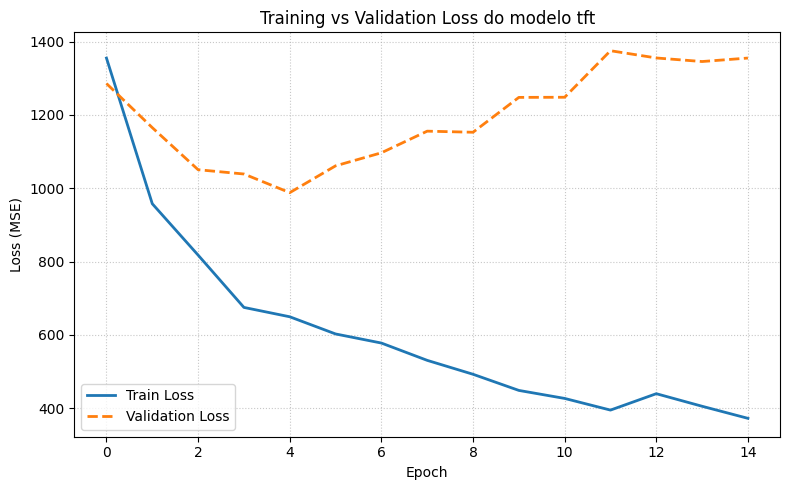

In [32]:
for model_name in histories.keys():
    print(f"Histórico de treinamento do modelo: {model_name}...")
    plot_training_history(histories[model_name], model_name)